In [1]:
# coding: utf-8

# In[7]:

import sys,os
import numpy as np
import dicom
import glob
import matplotlib
# matplotlib.use('Agg')
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import time
from sklearn import cross_validation
from lightgbm.sklearn import LGBMRegressor
from resnet50 import ResNet50
from keras.preprocessing import image
#from imagenet_utils import preprocess_input
#from PIL import Image
#from resizeimage import resizeimage

/a/data/mango/environments/newtf/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
/a/data/mango/environments/newtf/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
import errno
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise
EXPERIMENT_NUMBER = 'resNet' 

#Put here the path where you downloaded all kaggle data
DATA_PATH='data/'

# Path and variables
STAGE1_LABELS=DATA_PATH + 'stage1_labels.csv'
STAGE1_SAMPLE_SUBMISSION=DATA_PATH + 'stage1_sample_submission.csv'
STAGE1_FOLDER=DATA_PATH + 'stage1/'
FEATURE_FOLDER=DATA_PATH + 'features/features' + EXPERIMENT_NUMBER + '/'
SUBMIT_OUTPUT='submit' + EXPERIMENT_NUMBER + '.csv'

make_sure_path_exists(FEATURE_FOLDER)

In [3]:
# Timer class
class Timer(object):
    def __enter__(self):
        self.start()
        return self

    def __exit__(self, *args):
        self.stop()

    def start(self):
        self.start = time.clock()

    def stop(self):
        self.end = time.clock()
        self.interval = self.end - self.start


In [4]:
def get_3d_data(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return np.stack([s.pixel_array for s in slices])

In [5]:
def get_data_id(path, plot_data=False):
    sample_image = get_3d_data(path)
    sample_image[sample_image == -2000] = 0
    #if plot_data:
    #    f, plots = plt.subplots(4, 5, sharex='col', sharey='row', figsize=(10, 8))

    batch = []
    cnt = 0
    dx = 40
    ds = 512
    for i in range(0, sample_image.shape[0] - 3, 3):
        tmp = []
        for j in range(3):
            img = sample_image[i + j]
            img = 255.0 / np.amax(img) * img
            img = cv2.equalizeHist(img.astype(np.uint8))
            img = img.astype(np.uint8)
            img = img[dx: ds - dx, dx: ds - dx]
            img = cv2.resize(img, (224, 224))
            tmp.append(img)

        tmp = np.array(tmp)
        tmp = np.swapaxes(tmp,0,2) #we need to make "color" dimension last I think
        batch.append(np.array(tmp))

#         if plot_data:
#             if cnt < 20:
#                 plots[cnt // 5, cnt % 5].axis('off')
#                 plots[cnt // 5, cnt % 5].imshow(tmp[0,:,:], cmap='gray')
#             cnt += 1

#     if plot_data: plt.show()
        
    batch = np.array(batch, dtype='int')
    return batch



In [6]:
def get_model():
    model = ResNet50(weights='imagenet', include_top=False)
    return model

In [7]:
def calc_features(verbose=False):
    model = get_model()
    for folder in glob.glob(STAGE1_FOLDER+'*'):
        foldername = os.path.basename(folder)
        if os.path.isfile(FEATURE_FOLDER+foldername+'.npy'):
            if verbose: print("Features in %s already computed" % (FEATURE_FOLDER+foldername))
            continue
        batch = get_data_id(folder)
        if verbose:
            print("Batch size:")
            print(batch.shape)
        feats = model.predict(batch, batch_size=52, verbose=1)

        if verbose:
            print(feats.shape)
            print("Saving features in %s" % (FEATURE_FOLDER+foldername))
        np.save(FEATURE_FOLDER+foldername, feats)

In [ ]:
        
#%%time
# Calculate features
calc_features(verbose=False)

In [8]:
# In[25]:

def train_lightgbm():
    df = pd.read_csv(STAGE1_LABELS)

    x = np.array([np.mean(np.load(FEATURE_FOLDER+'%s.npy' % str(id)), axis=0).flatten() for id in df['id'].tolist()])
    y = df['cancer'].as_matrix()

    trn_x, val_x, trn_y, val_y = cross_validation.train_test_split(x, y, random_state=42, stratify=y,
                                                                   test_size=0.20)
    clf = LGBMRegressor(max_depth=50,
                        num_leaves=21,
                        n_estimators=5000,
                        min_child_weight=1,
                        learning_rate=0.001,
                        nthread=24,
                        subsample=0.80,
                        colsample_bytree=0.80,
                        seed=42)
    clf.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], verbose=True, eval_metric='l2', early_stopping_rounds=900)
    return clf

In [9]:
def compute_training(verbose=True):
    with Timer() as t:
        clf = train_lightgbm()
    if verbose: print("Training took %.03f sec.\n" % t.interval)
    return clf

In [10]:
def compute_prediction(clf, verbose=True):    
    df = pd.read_csv(STAGE1_SAMPLE_SUBMISSION)
    x = np.array([np.mean(np.load((FEATURE_FOLDER+'%s.npy') % str(id)), axis=0).flatten() for id in df['id'].tolist()])
    
    with Timer() as t:
        pred = clf.predict(x)
    if verbose: print("Prediction took %.03f sec.\n" % t.interval)
    df['cancer'] = pred
    return df

In [11]:
def save_results(df):
    df.to_csv(SUBMIT_OUTPUT, index=False)

In [12]:
clf = compute_training(verbose=True)

[1]	valid_0's l2: 0.510488
Train until valid scores didn't improve in 900 rounds.
[2]	valid_0's l2: 0.510383
[3]	valid_0's l2: 0.510248
[4]	valid_0's l2: 0.510139
[5]	valid_0's l2: 0.509987
[6]	valid_0's l2: 0.509828
[7]	valid_0's l2: 0.509696
[8]	valid_0's l2: 0.50958
[9]	valid_0's l2: 0.509491
[10]	valid_0's l2: 0.509325
[11]	valid_0's l2: 0.509189
[12]	valid_0's l2: 0.509065
[13]	valid_0's l2: 0.508955
[14]	valid_0's l2: 0.508833
[15]	valid_0's l2: 0.508715
[16]	valid_0's l2: 0.508579
[17]	valid_0's l2: 0.508448
[18]	valid_0's l2: 0.508319
[19]	valid_0's l2: 0.508173
[20]	valid_0's l2: 0.508034
[21]	valid_0's l2: 0.507871
[22]	valid_0's l2: 0.507742
[23]	valid_0's l2: 0.507572
[24]	valid_0's l2: 0.507409
[25]	valid_0's l2: 0.507284
[26]	valid_0's l2: 0.507186
[27]	valid_0's l2: 0.507052
[28]	valid_0's l2: 0.506907
[29]	valid_0's l2: 0.506758
[30]	valid_0's l2: 0.50664
[31]	valid_0's l2: 0.506469
[32]	valid_0's l2: 0.506334
[33]	valid_0's l2: 0.506195
[34]	valid_0's l2: 0.506048
[35]

[288]	valid_0's l2: 0.479035
[289]	valid_0's l2: 0.478952
[290]	valid_0's l2: 0.478895
[291]	valid_0's l2: 0.478814
[292]	valid_0's l2: 0.478726
[293]	valid_0's l2: 0.47864
[294]	valid_0's l2: 0.478565
[295]	valid_0's l2: 0.478471
[296]	valid_0's l2: 0.478392
[297]	valid_0's l2: 0.478311
[298]	valid_0's l2: 0.478222
[299]	valid_0's l2: 0.478141
[300]	valid_0's l2: 0.478043
[301]	valid_0's l2: 0.477973
[302]	valid_0's l2: 0.477902
[303]	valid_0's l2: 0.477846
[304]	valid_0's l2: 0.47776
[305]	valid_0's l2: 0.477677
[306]	valid_0's l2: 0.477578
[307]	valid_0's l2: 0.477516
[308]	valid_0's l2: 0.477433
[309]	valid_0's l2: 0.477338
[310]	valid_0's l2: 0.477248
[311]	valid_0's l2: 0.477184
[312]	valid_0's l2: 0.477158
[313]	valid_0's l2: 0.477072
[314]	valid_0's l2: 0.476999
[315]	valid_0's l2: 0.476897
[316]	valid_0's l2: 0.476832
[317]	valid_0's l2: 0.476722
[318]	valid_0's l2: 0.476645
[319]	valid_0's l2: 0.476549
[320]	valid_0's l2: 0.476438
[321]	valid_0's l2: 0.476358
[322]	valid_0's 

[572]	valid_0's l2: 0.460279
[573]	valid_0's l2: 0.460244
[574]	valid_0's l2: 0.460187
[575]	valid_0's l2: 0.460141
[576]	valid_0's l2: 0.460092
[577]	valid_0's l2: 0.460032
[578]	valid_0's l2: 0.459992
[579]	valid_0's l2: 0.459964
[580]	valid_0's l2: 0.45993
[581]	valid_0's l2: 0.459874
[582]	valid_0's l2: 0.459845
[583]	valid_0's l2: 0.459796
[584]	valid_0's l2: 0.45976
[585]	valid_0's l2: 0.4597
[586]	valid_0's l2: 0.459645
[587]	valid_0's l2: 0.459592
[588]	valid_0's l2: 0.45957
[589]	valid_0's l2: 0.45954
[590]	valid_0's l2: 0.459476
[591]	valid_0's l2: 0.459436
[592]	valid_0's l2: 0.459371
[593]	valid_0's l2: 0.459347
[594]	valid_0's l2: 0.459311
[595]	valid_0's l2: 0.459243
[596]	valid_0's l2: 0.459196
[597]	valid_0's l2: 0.45914
[598]	valid_0's l2: 0.459089
[599]	valid_0's l2: 0.459054
[600]	valid_0's l2: 0.459009
[601]	valid_0's l2: 0.458938
[602]	valid_0's l2: 0.458882
[603]	valid_0's l2: 0.458816
[604]	valid_0's l2: 0.458779
[605]	valid_0's l2: 0.458736
[606]	valid_0's l2: 0

KeyboardInterrupt: 

In [13]:
df = compute_prediction(clf)
print("Results:")
df.head()
save_results(df)

Prediction took 0.070 sec.

Results:


come into file
merge csv                                    id  cancer_x   Usage  cancer_y
0    026470d51482c93efc18b9803159c960         1  Public  0.224245
1    031b7ec4fe96a3b035a8196264a8c8c3         1  Public  0.251712
2    03bd22ed5858039af223c04993e9eb22         0  Public  0.240973
3    06a90409e4fcea3e634748b967993531         0  Public  0.145713
4    07b1defcfae5873ee1f03c90255eb170         1  Public  0.376370
5    0b20184e0cd497028bdd155d9fb42dc9         0  Public  0.200642
6    12db1ea8336eafaf7f9e3eda2b4e4fef         0  Public  0.157794
7    159bc8821a2dc39a1e770cb3559e098d         0  Public  0.202305
8    174c5f7c33ca31443208ef873b9477e5         0  Public  0.214435
9    1753250dab5fc81bab8280df13309733         0  Public  0.172557
10   1cf8e778167d20bf769669b4be96592b         0  Public  0.107803
11   1e62be2c3b6430b78ce31a8f023531ac         1  Public  0.363870
12   1f6333bc3599f683403d6f0884aefe00         0  Public  0.149242
13   1fdbc07019192de4a114e090389c8330         1  Pu

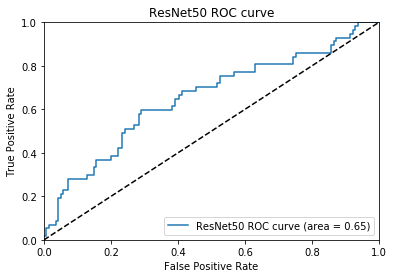

0.576311323647


In [14]:
import pandas as pd
import numpy as np 
import pylab as pl 
from sklearn.metrics import roc_curve, auc
print 'come into file'
df_1 = pd.read_csv('stage1_solution.csv')
df_2 = pd.read_csv('submitresNet.csv')
merge = df_1.merge(df_2, on = 'id')
print 'merge csv', merge
keep_cols = ['cancer_x', 'cancer_y']
df = merge[keep_cols]
print 'finish reading csv file'
y_test = np.array(df)[:,0]
probas = np.array(df)[:,1]
# print y_test
# print 'probas', probas
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas)
print 'thresholds', thresholds
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

pl.clf()
pl.plot(fpr, tpr, label='ResNet50 ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('ResNet50 ROC curve')
pl.legend(loc="lower right")
pl.show()

from sklearn import metrics
print (metrics.log_loss(y_test, probas))
